# Exploratory V2
- This notebook builds off of the analysis in the original exploratory.ipynb notebook, but utilizes a larger more robust data set (PLAYER_TOURNAMENT_RESULTS_V3)

In [1]:
import sqlite3
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Data/PGA_SQL_DB/PGA.db')

## Correlation Between Weather and Golf Scores

### Pull Weather Data

In [2]:
weather_query = """WITH
    TOURNAMENT_ROUND_AVGS AS (
        SELECT TOURNAMENT_NAME, 
            AVG(R1_SCORE - PAR) AS R1_AVG_SCORE,
            AVG(R2_SCORE - PAR) AS R2_AVG_SCORE,
            AVG(R3_SCORE - PAR) AS R3_AVG_SCORE,
            AVG(R4_SCORE - PAR) AS R4_AVG_SCORE
        FROM PLAYER_TOURNAMENT_RESULTS_V3
        GROUP BY 1
    )

SELECT DISTINCT PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME,ELEVATION,
    R1_TEMP, R1_PRECIP, R1_WIND_SPEED, R1_WIND_DIRECT,
    R2_TEMP, R2_PRECIP, R2_WIND_SPEED, R2_WIND_DIRECT,
    R3_TEMP, R3_PRECIP, R3_WIND_SPEED, R3_WIND_DIRECT,
    R4_TEMP, R4_PRECIP, R4_WIND_SPEED, R4_WIND_DIRECT,
    R1_AVG_SCORE, R2_AVG_SCORE, R3_AVG_SCORE, R4_AVG_SCORE
FROM PLAYER_TOURNAMENT_RESULTS_V3
    INNER JOIN TOURNAMENT_ROUND_AVGS ON TOURNAMENT_ROUND_AVGS.TOURNAMENT_NAME = PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME
ORDER BY PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME"""

weather_df = pd.read_sql_query(weather_query, conn)
weather_df

,TOURNAMENT_NAME,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,R2_TEMP,R2_PRECIP,R2_WIND_SPEED,R2_WIND_DIRECT,...,R3_WIND_SPEED,R3_WIND_DIRECT,R4_TEMP,R4_PRECIP,R4_WIND_SPEED,R4_WIND_DIRECT,R1_AVG_SCORE,R2_AVG_SCORE,R3_AVG_SCORE,R4_AVG_SCORE
0,2017 PGA Championship,254.0,73.6,0.000,7.3,124,75.1,0.685,9.0,194,...,7.8,209,78.1,0.035,7.5,47,0.986301,0.328767,1.191781,0.835616
1,2017 RBC Canadian Open,95.0,70.4,0.276,7.9,224,68.4,0.000,10.7,31,...,11.4,11,75.2,0.000,10.5,333,-3.813333,-2.706667,-2.266667,-1.413333
2,2017 Sanderson Farms Championship,94.0,59.1,0.000,10.3,210,63.8,0.016,12.8,185,...,15.7,340,45.9,0.000,6.3,303,-2.208333,-1.388889,0.069444,0.277778
3,2017 THE PLAYERS Championship,6.0,78.9,0.000,9.1,245,79.1,0.000,14.5,254,...,11.5,214,72.6,0.031,14.8,21,-0.845070,-0.478873,1.323944,1.605634
4,2017 The Greenbrier Classic,564.0,72.9,0.181,10.2,264,74.5,0.055,10.8,281,...,13.1,282,70.1,0.000,6.9,278,-1.943662,-1.605634,0.098592,-0.859155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2024 The Genesis Invitational,106.0,51.8,0.000,7.1,266,55.0,0.000,8.7,352,...,5.9,68,54.8,0.055,5.6,119,-1.720000,-1.320000,-1.740000,-0.540000
70,2024 U.S. Open,165.0,76.2,0.004,8.4,117,77.5,0.016,8.5,157,...,8.1,13,79.8,0.004,8.6,104,1.222222,0.708333,3.138889,1.750000
71,2024 Valero Texas Open,201.0,68.4,0.000,11.1,247,70.2,0.000,17.1,179,...,18.6,158,72.5,0.008,14.1,65,-0.695122,-0.512195,0.414634,-1.317073
72,2024 Wells Fargo Championship,254.0,70.2,0.075,15.5,231,69.7,0.012,16.3,269,...,12.8,324,64.5,0.000,10.8,301,-0.060606,-0.121212,1.803030,1.287879


### View Relationship Between Different Metrics and Score to Par

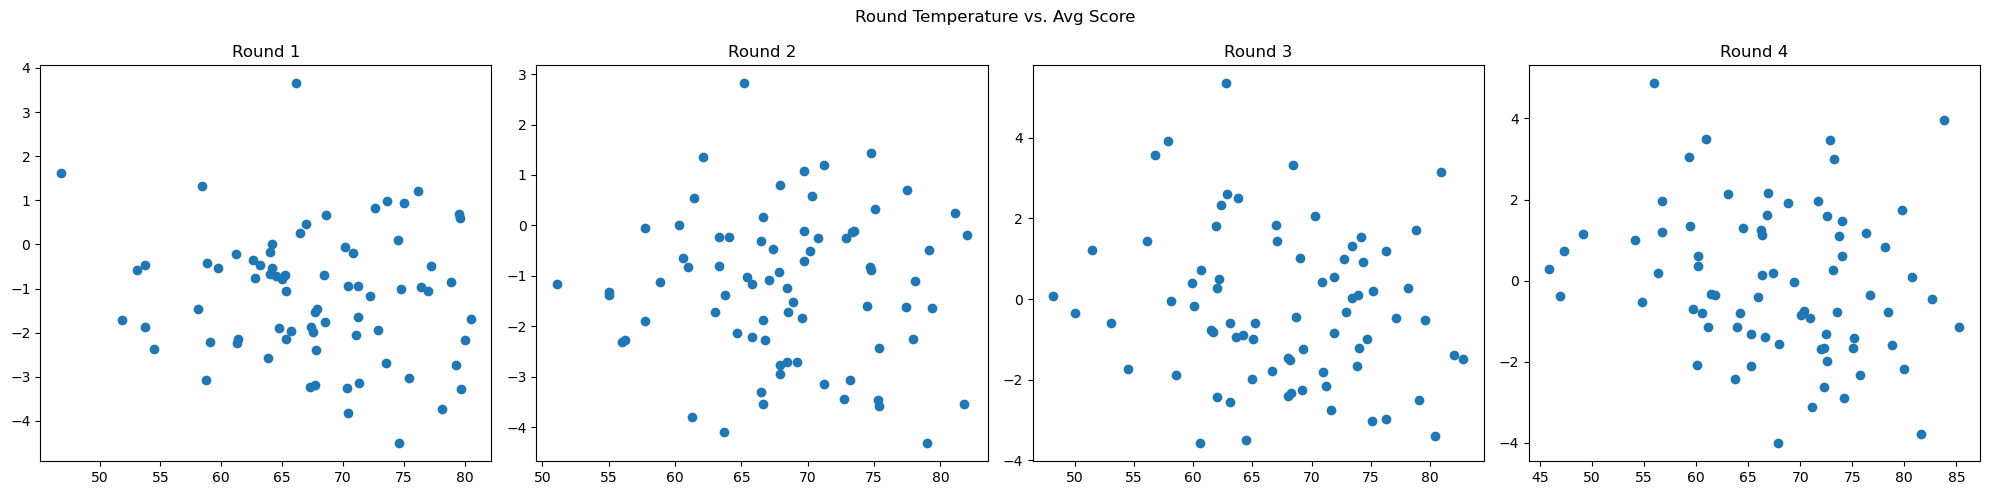

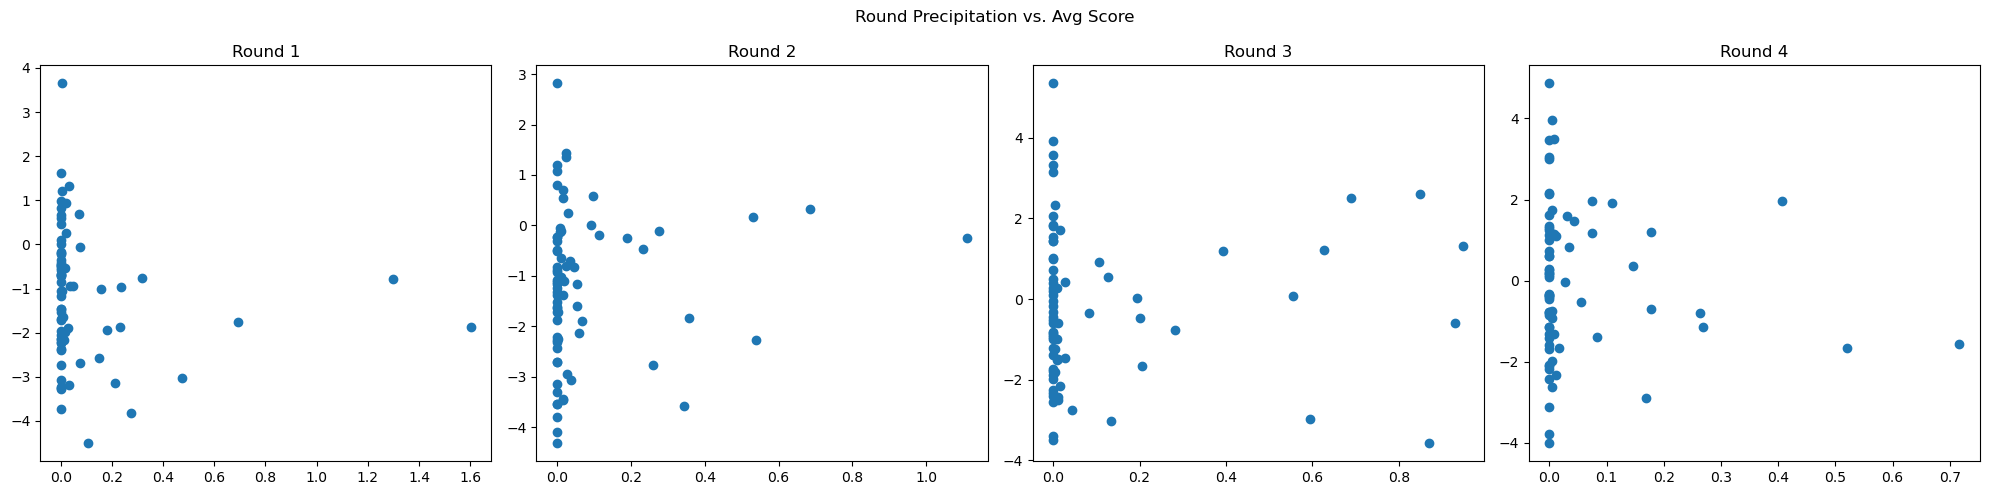

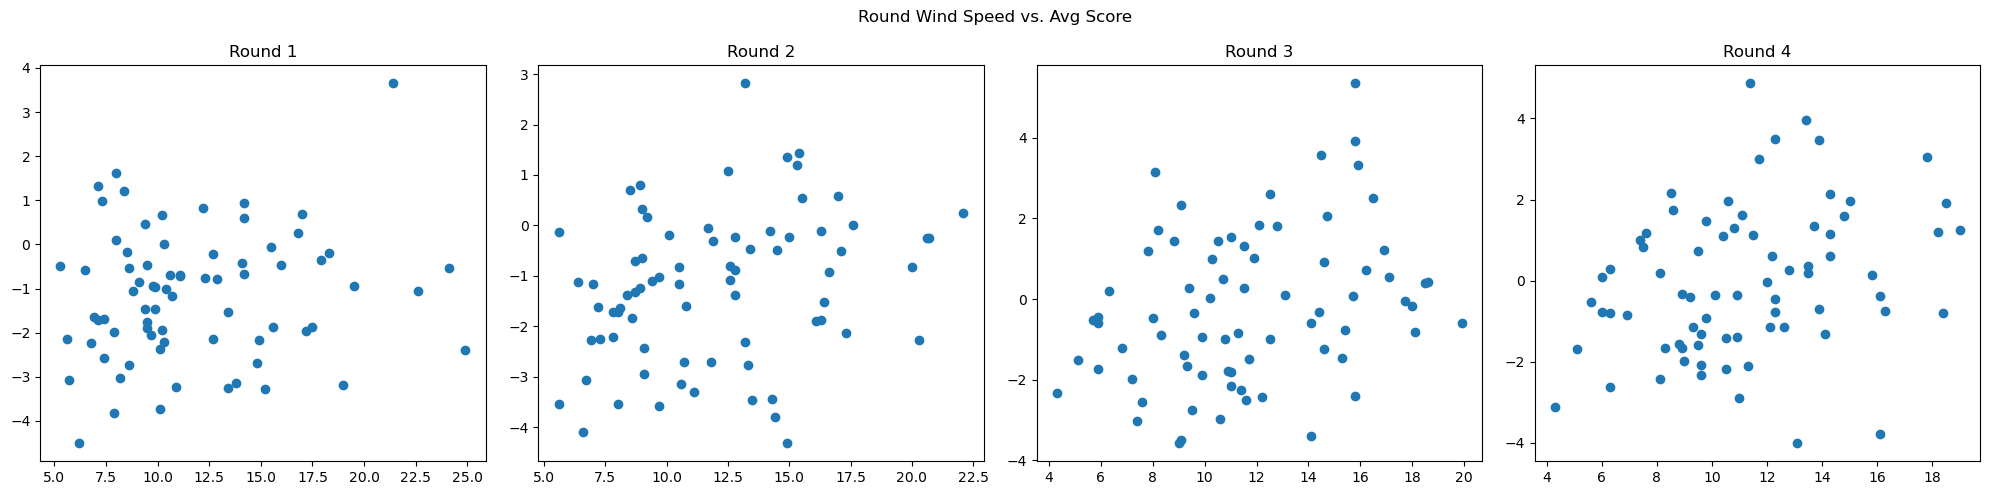

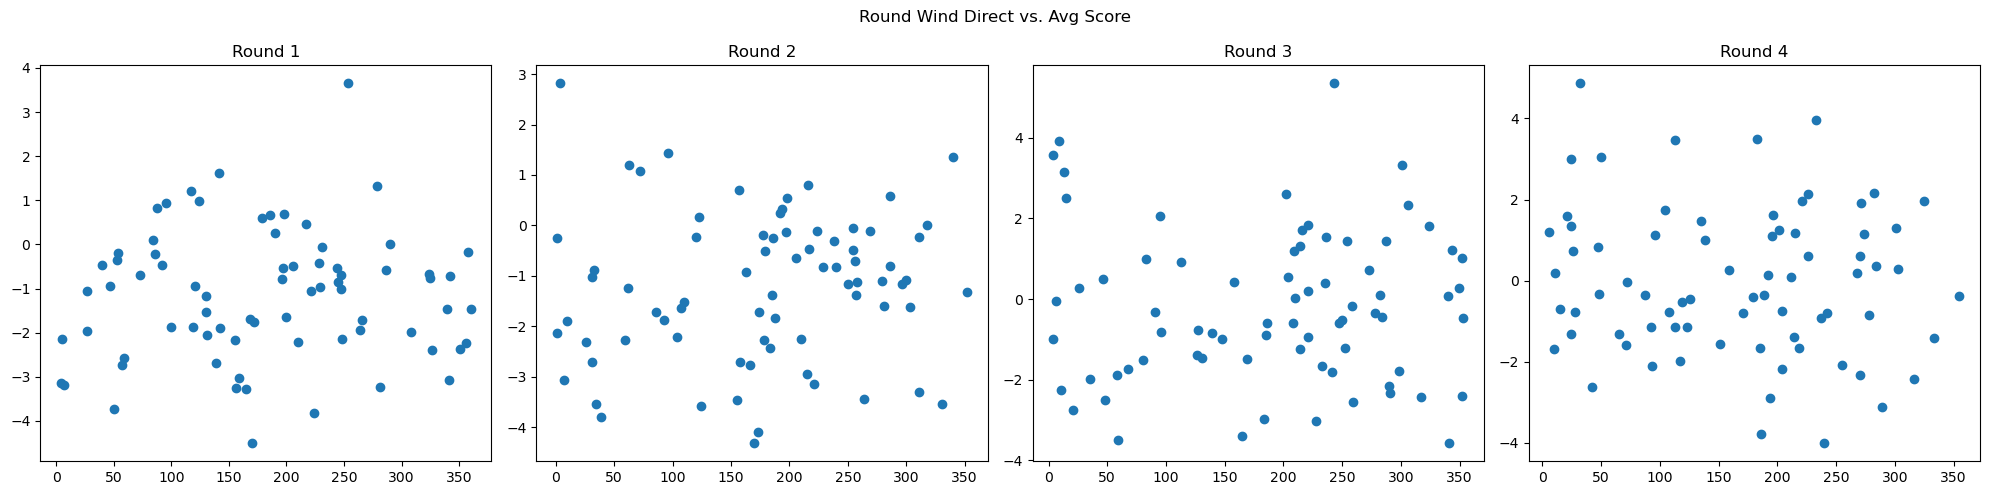

<Figure size 640x480 with 0 Axes>

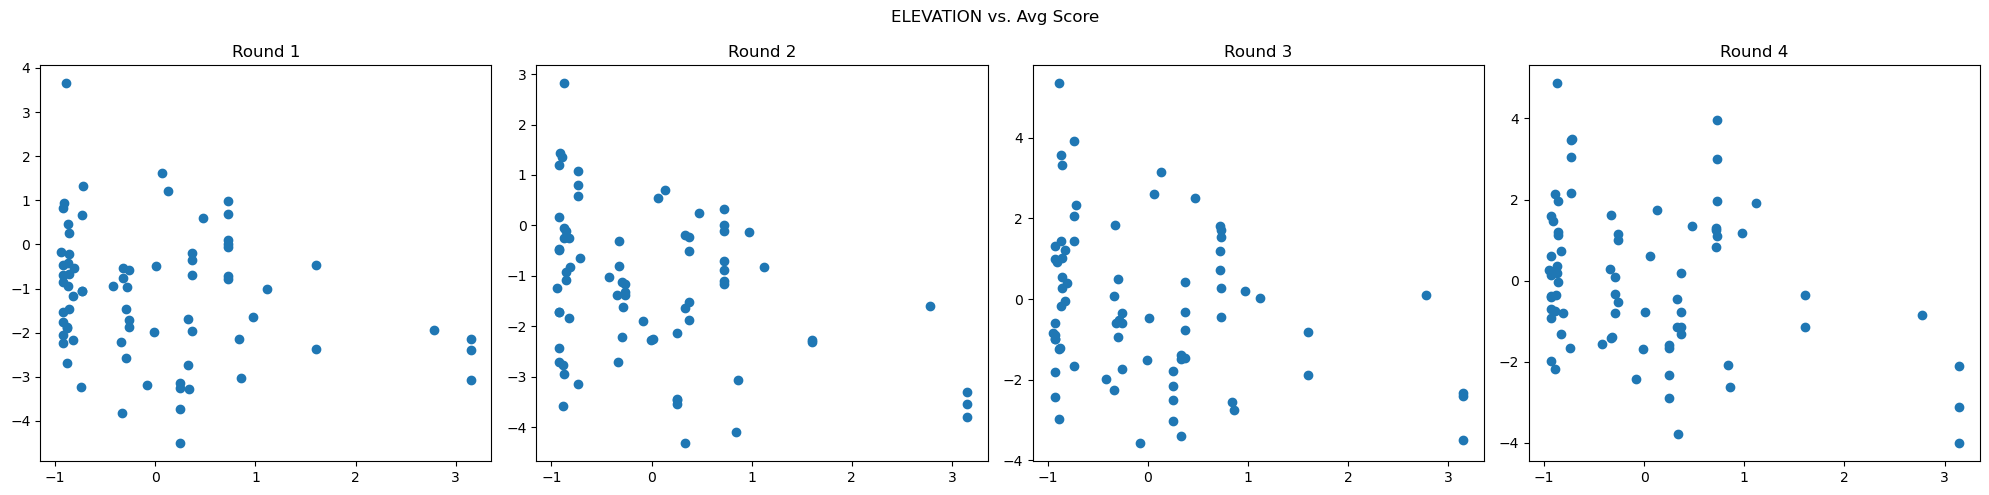

In [3]:
round_feature_mapping = {1: ['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT', 'ELEVATION', 'R1_AVG_SCORE'],
                        2: ['R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 'R2_WIND_DIRECT', 'ELEVATION', 'R2_AVG_SCORE'],
                        3: ['R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 'R3_WIND_DIRECT', 'ELEVATION', 'R3_AVG_SCORE'],
                        4: ['R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'R4_WIND_DIRECT', 'ELEVATION', 'R4_AVG_SCORE']}

scaler = StandardScaler()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Temperature vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][0]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Precipitation vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][1]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Wind Speed vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][2]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Wind Direct vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][3]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('ELEVATION vs. Avg Score')
weather_df[['ELEVATION']] = scaler.fit_transform(weather_df[['ELEVATION']])
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][4]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

### Create an Aggregate Weather Feature to Summarize Weather Conditions

In [4]:
# Create weather feature (Weighted average of temp, precipiation, and wind speed)
def weather_weighted_average(temp, precip, wind_speed, elevation):
    weights = [0.1, 0.4, 0.2, 0.3]
    return (temp * -1 * weights[0] + elevation * -1 *weights[1] + precip * weights[2] + wind_speed * weights[3]) / (weights[0] + weights[1] + weights[2] + weights[3])

scaler = StandardScaler()
weather_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 'R2_WIND_DIRECT',
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 'R3_WIND_DIRECT', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'R4_WIND_DIRECT', 'ELEVATION']] = scaler.fit_transform(weather_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 'R2_WIND_DIRECT', 
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 'R3_WIND_DIRECT', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'R4_WIND_DIRECT', 'ELEVATION']])

weather_df['R1_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R1_TEMP'], row['R1_PRECIP'], row['R1_WIND_SPEED'], row['ELEVATION']), axis=1)
weather_df['R2_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R2_TEMP'], row['R2_PRECIP'], row['R2_WIND_SPEED'], row['ELEVATION']), axis=1)
weather_df['R3_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R3_TEMP'], row['R3_PRECIP'], row['R3_WIND_SPEED'], row['ELEVATION']), axis=1)
weather_df['R4_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R4_TEMP'], row['R4_PRECIP'], row['R4_WIND_SPEED'], row['ELEVATION']), axis=1)

weather_df

,TOURNAMENT_NAME,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,R2_TEMP,R2_PRECIP,R2_WIND_SPEED,R2_WIND_DIRECT,...,R4_WIND_SPEED,R4_WIND_DIRECT,R1_AVG_SCORE,R2_AVG_SCORE,R3_AVG_SCORE,R4_AVG_SCORE,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR
0,2017 PGA Championship,0.720904,0.782085,-0.339723,-1.005710,-0.588138,0.967667,3.390345,-0.753489,0.180443,...,-1.079422,-1.219188,0.986301,0.328767,1.191781,0.835616,-0.736228,0.066894,-0.473422,-0.749088
1,2017 RBC Canadian Open,-0.334091,0.356147,0.738857,-0.871212,0.423301,-0.002152,-0.410447,-0.328617,-1.526623,...,-0.200685,1.764151,-3.813333,-2.706667,-2.266667,-1.413333,-0.015571,-0.046823,0.002443,-0.088696
2,2017 Sanderson Farms Championship,-0.340726,-1.147946,-0.339723,-0.333217,0.281699,-0.667997,-0.321669,0.196225,0.086188,...,-1.430917,1.451213,-2.208333,-1.388889,0.069444,0.277778,0.083175,0.197624,1.078073,-0.124531
3,2017 THE PLAYERS Championship,-0.924622,1.487545,-0.339723,-0.602215,0.635703,1.546663,-0.410447,0.621097,0.808811,...,1.058839,-1.490401,-0.845070,-0.478873,1.323944,1.605634,-0.027515,0.319422,0.979062,0.606033
4,2017 The Greenbrier Classic,2.777811,0.688911,0.367607,-0.355634,0.827876,0.880818,-0.105273,-0.303625,1.091577,...,-1.255170,1.190432,-1.943662,-1.605634,0.098592,-0.859155,-1.213185,-1.311348,-1.165329,-1.592261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2024 The Genesis Invitational,-0.261104,-2.119617,-0.339723,-1.050543,0.848105,-1.941789,-0.410447,-0.828467,1.835146,...,-1.635956,-0.468138,-1.720000,-1.320000,-1.740000,-0.540000,-0.066705,-0.032009,-0.282276,-0.227247
70,2024 U.S. Open,0.130372,1.128160,-0.324092,-0.759130,-0.658938,1.315065,-0.321669,-0.878452,-0.207050,...,-0.757218,-0.624607,1.222222,0.708333,3.138889,1.750000,-0.457522,-0.511525,-0.597876,-0.486719
71,2024 Valero Texas Open,0.369239,0.089936,-0.339723,-0.153886,0.655931,0.258397,-0.410447,1.270901,0.023352,...,0.853800,-1.031425,-0.695122,-0.512195,0.414634,-1.317073,-0.270800,0.125646,0.302130,-0.009974
72,2024 Wells Fargo Championship,0.720904,0.329526,-0.046631,0.832437,0.494101,0.186022,-0.343863,1.070961,0.965903,...,-0.112811,1.430350,-0.060606,-0.121212,1.803030,1.287879,-0.080909,-0.054448,-0.213951,-0.363608


#### View the relationship between new weather feature and score to par

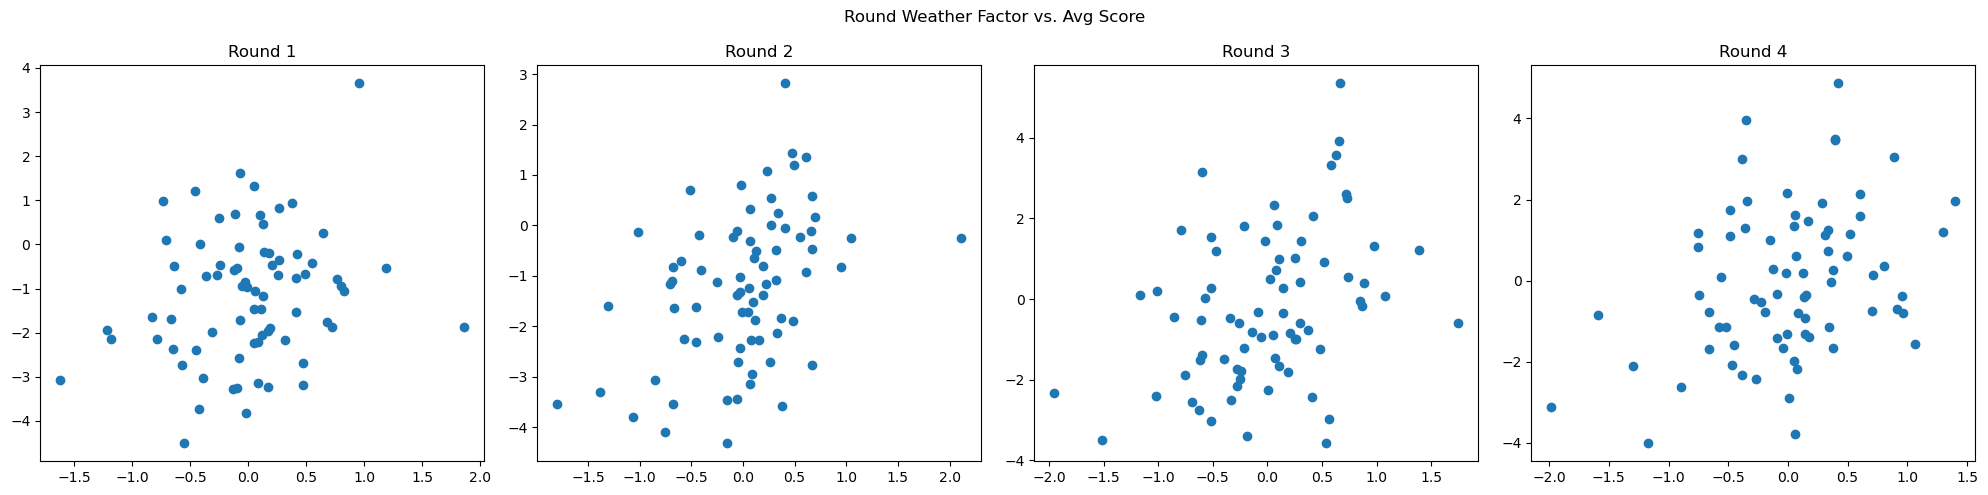

Round 1; Correlation: [0.2115861550049835], p-value: [0.07034318339582678]
Round 2; Correlation: [0.41809755372073903], p-value: [0.00020997859630996691]
Round 3; Correlation: [0.3658045174079986], p-value: [0.0013503504007818144]
Round 4; Correlation: [0.3455182516653974], p-value: [0.0025689051800810957]


In [5]:
# Vizualize relationship between weather factor and scrore to par
round_feature_mapping = {1: ['R1_WEATHER_FACTOR', 'R1_AVG_SCORE'],
                        2: ['R2_WEATHER_FACTOR', 'R2_AVG_SCORE'],
                        3: ['R3_WEATHER_FACTOR', 'R3_AVG_SCORE'],
                        4: ['R4_WEATHER_FACTOR', 'R4_AVG_SCORE']}

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Weather Factor vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][0]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][1]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

# Correlation between weather factor and score to par
r1_corr, r1_p_value = pearsonr(weather_df['R1_WEATHER_FACTOR'], weather_df['R1_AVG_SCORE'])
r2_corr, r2_p_value = pearsonr(weather_df['R2_WEATHER_FACTOR'], weather_df['R2_AVG_SCORE'])
r3_corr, r3_p_value = pearsonr(weather_df['R3_WEATHER_FACTOR'], weather_df['R3_AVG_SCORE'])
r4_corr, r4_p_value = pearsonr(weather_df['R4_WEATHER_FACTOR'], weather_df['R4_AVG_SCORE'])

print(f"Round 1; Correlation: [{r1_corr}], p-value: [{r1_p_value}]")
print(f"Round 2; Correlation: [{r2_corr}], p-value: [{r2_p_value}]")
print(f"Round 3; Correlation: [{r3_corr}], p-value: [{r3_p_value}]")
print(f"Round 4; Correlation: [{r4_corr}], p-value: [{r4_p_value}]")

- A larger weather factor for a round results in larger tournament scores to par (i.e. -10 means 10 under for the tournament).
- Significant increase from the correlation found in the initital exploratory results

## Correlation Between Historical Player Statistics and Score

### Strokes Gained Putting
- Account for course difficulty simply by subtracting the average strokes for that tournament from that value.
- Determine the best way to aggrgate historical strokes gained data to predict a golfers score
    - Will use some sort of exponential weighting that prioritizes more recent data

#### Pull Strokes Gained Putting Data

In [8]:
strokes_gained_query = """WITH TOURNAMENT_AVERAGES AS (
    SELECT TOURNAMENT_NAME,
        AVG(SG_PUTT) AS TOURN_AVG_SG_PUTT
    FROM PLAYER_TOURNAMENT_RESULTS_V3
    GROUP BY 1
)
     

SELECT PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME, SG_PUTT, TOURN_AVG_SG_PUTT, SG_PUTT - TOURN_AVG_SG_PUTT AS ADJ_SG_PUTT,
    R1_SCORE - PAR AS R1_SCORE_TO_PAR,
    R2_SCORE - PAR AS R2_SCORE_TO_PAR,
    R3_SCORE - PAR AS R3_SCORE_TO_PAR,
    R4_SCORE - PAR AS R4_SCORE_TO_PAR
FROM PLAYER_TOURNAMENT_RESULTS_V3
INNER JOIN TOURNAMENT_AVERAGES ON PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME = TOURNAMENT_AVERAGES.TOURNAMENT_NAME
ORDER BY PLAYER_NAME, PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_DATE"""

strokes_gained_df = pd.read_sql_query(strokes_gained_query, conn)
strokes_gained_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,SG_PUTT,TOURN_AVG_SG_PUTT,ADJ_SG_PUTT,R1_SCORE_TO_PAR,R2_SCORE_TO_PAR,R3_SCORE_TO_PAR,R4_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,1.19375,0.314958,0.878792,-2,1,4,0
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,0.49900,0.265542,0.233458,-3,-4,2,1
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,-0.28450,0.406461,-0.690961,-1,-1,-4,-1
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,0.02150,0.400420,-0.378920,4,2,7,-1
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,1.05650,0.293667,0.762833,-2,0,0,2
...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,-0.11850,0.389971,-0.508471,-3,-3,2,1
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,-0.00500,0.406461,-0.411461,-1,-1,1,1
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,-1.66275,0.266493,-1.929243,-3,2,6,8
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,0.15875,0.279135,-0.120385,0,-2,1,9


#### Calculate Historicallly Weighted Averages based on Different Half Life Values

In [9]:
def convert_string_to_date(date_string):
    return datetime.strptime(date_string, "%Y-%m-%d")

def compute_days_between(date_one, date_two):
    duration = date_two - date_one
    return duration.days

def compute_half_life_weight(half_life, days):
    return np.power(0.5, (days / half_life))

# for each row, need to look at all previous tournaments for that player. and calculate weights based on the different between that rows tournament date and the other rows tournament weight.
def calc_weighted_avgs(df, player_name, tournament_date, feature):
    prev_rounds_df = df.copy()
    tournament_date = convert_string_to_date(tournament_date)
    prev_rounds_df.loc[:, 'TOURNAMENT_DATE'] = prev_rounds_df.apply(lambda row: convert_string_to_date(row['TOURNAMENT_DATE']), axis=1)
    prev_rounds_df = prev_rounds_df.loc[(prev_rounds_df['PLAYER_NAME'] == player_name) & (prev_rounds_df['TOURNAMENT_DATE'] < tournament_date)]

    if prev_rounds_df.shape[0] == 0:
        return None

    prev_rounds_df['DAYS_SINCE'] = prev_rounds_df.apply(lambda row: compute_days_between(row['TOURNAMENT_DATE'], tournament_date), axis=1)
    prev_rounds_df['HL_25_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(25, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_50_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(50, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_100_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(100, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_200_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(200, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_400_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(400, row['DAYS_SINCE']), axis=1)

    weight_sum_HL_25 = prev_rounds_df['HL_25_WEIGHT'].sum()
    weight_sum_HL_50 = prev_rounds_df['HL_50_WEIGHT'].sum()
    weight_sum_HL_100 = prev_rounds_df['HL_100_WEIGHT'].sum()
    weight_sum_HL_200 = prev_rounds_df['HL_200_WEIGHT'].sum()
    weight_sum_HL_400 = prev_rounds_df['HL_400_WEIGHT'].sum()
    prev_rounds_df['HL_25_WEIGHTED_FEATURE'] = prev_rounds_df['HL_25_WEIGHT'] * prev_rounds_df[feature]
    prev_rounds_df['HL_50_WEIGHTED_FEATURE'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[feature]
    prev_rounds_df['HL_100_WEIGHTED_FEATURE'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[feature]
    prev_rounds_df['HL_200_WEIGHTED_FEATURE'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[feature]
    prev_rounds_df['HL_400_WEIGHTED_FEATURE'] = prev_rounds_df['HL_400_WEIGHT'] * prev_rounds_df[feature]
    weighted_feature_sum_HL_25 = prev_rounds_df['HL_25_WEIGHTED_FEATURE'].sum()
    weighted_feature_sum_HL_50 = prev_rounds_df['HL_50_WEIGHTED_FEATURE'].sum()
    weighted_feature_sum_HL_100 = prev_rounds_df['HL_100_WEIGHTED_FEATURE'].sum()
    weighted_feature_sum_HL_200 = prev_rounds_df['HL_200_WEIGHTED_FEATURE'].sum()
    weighted_feature_sum_HL_400 = prev_rounds_df['HL_400_WEIGHTED_FEATURE'].sum()

    return (weighted_feature_sum_HL_25 / weight_sum_HL_25), (weighted_feature_sum_HL_50 /  weight_sum_HL_50), (weighted_feature_sum_HL_100 /  weight_sum_HL_100), (weighted_feature_sum_HL_200 /  weight_sum_HL_200), (weighted_feature_sum_HL_400 /  weight_sum_HL_400)

# Apply the relevant half life values for each of the factors based on the half-life values from the research paper
strokes_gained_df[['HL_25_ADJ_SG_PUTT', 'HL_50_ADJ_SG_PUTT', 'HL_100_ADJ_SG_PUTT', 'HL_200_ADJ_SG_PUTT', 'HL_400_ADJ_SG_PUTT']] = strokes_gained_df.apply(lambda row: pd.Series(calc_weighted_avgs(strokes_gained_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], "ADJ_SG_PUTT")), axis=1)
strokes_gained_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,SG_PUTT,TOURN_AVG_SG_PUTT,ADJ_SG_PUTT,R1_SCORE_TO_PAR,R2_SCORE_TO_PAR,R3_SCORE_TO_PAR,R4_SCORE_TO_PAR,HL_25_ADJ_SG_PUTT,HL_50_ADJ_SG_PUTT,HL_100_ADJ_SG_PUTT,HL_200_ADJ_SG_PUTT,HL_400_ADJ_SG_PUTT
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,1.19375,0.314958,0.878792,-2,1,4,0,NaN,NaN,NaN,NaN,NaN
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,0.49900,0.265542,0.233458,-3,-4,2,1,0.878792,0.878792,0.878792,0.878792,0.878792
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,-0.28450,0.406461,-0.690961,-1,-1,-4,-1,0.239522,0.290733,0.386953,0.464757,0.509487
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,0.02150,0.400420,-0.378920,4,2,7,-1,-0.683680,-0.604159,-0.388478,-0.160004,-0.014653
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,1.05650,0.293667,0.762833,-2,0,0,2,-0.432509,-0.454471,-0.383559,-0.246754,-0.132979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,-0.11850,0.389971,-0.508471,-3,-3,2,1,-0.043267,-0.079385,-0.102291,-0.114503,-0.120709
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,-0.00500,0.406461,-0.411461,-1,-1,1,1,NaN,NaN,NaN,NaN,NaN
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,-1.66275,0.266493,-1.929243,-3,2,6,8,-0.411461,-0.411461,-0.411461,-0.411461,-0.411461
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,0.15875,0.279135,-0.120385,0,-2,1,9,-1.929243,-1.929243,-1.929228,-1.924541,-1.849101


In [13]:
strokes_gained_df = strokes_gained_df.dropna()
strokes_gained_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,SG_PUTT,TOURN_AVG_SG_PUTT,ADJ_SG_PUTT,R1_SCORE_TO_PAR,R2_SCORE_TO_PAR,R3_SCORE_TO_PAR,R4_SCORE_TO_PAR,HL_25_ADJ_SG_PUTT,HL_50_ADJ_SG_PUTT,HL_100_ADJ_SG_PUTT,HL_200_ADJ_SG_PUTT,HL_400_ADJ_SG_PUTT
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,0.49900,0.265542,0.233458,-3,-4,2,1,0.878792,0.878792,0.878792,0.878792,0.878792
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,-0.28450,0.406461,-0.690961,-1,-1,-4,-1,0.239522,0.290733,0.386953,0.464757,0.509487
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,0.02150,0.400420,-0.378920,4,2,7,-1,-0.683680,-0.604159,-0.388478,-0.160004,-0.014653
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,1.05650,0.293667,0.762833,-2,0,0,2,-0.432509,-0.454471,-0.383559,-0.246754,-0.132979
5,2020 Waste Management Phoenix Open,2020-01-30,Aaron Baddeley,-0.37000,0.377659,-0.747659,-3,-1,1,-3,0.761209,0.704428,0.462131,0.238728,0.164284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,2019 3M Open,2019-07-04,Zack Sucher,0.26650,0.264826,0.001674,-3,0,-3,-1,-0.255563,-0.255563,-0.255563,-0.255563,-0.255563
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,-0.11850,0.389971,-0.508471,-3,-3,2,1,-0.043267,-0.079385,-0.102291,-0.114503,-0.120709
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,-1.66275,0.266493,-1.929243,-3,2,6,8,-0.411461,-0.411461,-0.411461,-0.411461,-0.411461
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,0.15875,0.279135,-0.120385,0,-2,1,9,-1.929243,-1.929243,-1.929228,-1.924541,-1.849101


#### Analyze the statistical significance of different weighted historical features

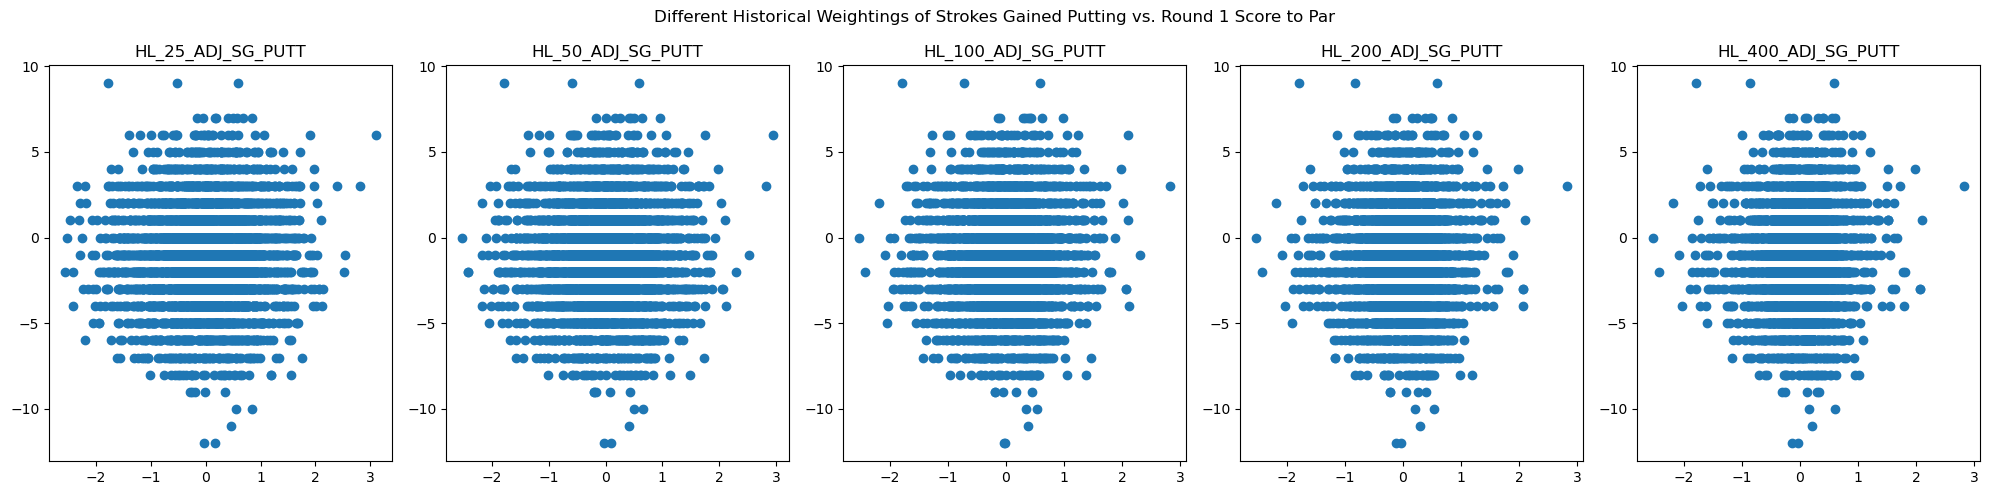

Half Life 25; Correlation: [0.008200076437450275], p-value: [0.5731604518258178]
Half Life 50; Correlation: [0.007983747902439251], p-value: [0.5833216605315604]
Half Life 100; Correlation: [0.0094700164552164], p-value: [0.5152656369255763]
Half Life 200; Correlation: [0.010468796520484474], p-value: [0.47196364541455166]
Half Life 400; Correlation: [0.00892582650153336], p-value: [0.5396984114825527]


In [14]:
round_feature_mapping = {1: ['HL_25_ADJ_SG_PUTT', 'R1_SCORE_TO_PAR'],
                        2: ['HL_50_ADJ_SG_PUTT', 'R1_SCORE_TO_PAR'],
                        3: ['HL_100_ADJ_SG_PUTT', 'R1_SCORE_TO_PAR'],
                        4: ['HL_200_ADJ_SG_PUTT', 'R1_SCORE_TO_PAR'],
                        5: ['HL_400_ADJ_SG_PUTT', 'R1_SCORE_TO_PAR']}

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Different Historical Weightings of Strokes Gained Putting vs. Round 1 Score to Par')
for key in round_feature_mapping:
    plt.subplot(1,5,key)
    plt.scatter(strokes_gained_df[round_feature_mapping[key][0]], strokes_gained_df[round_feature_mapping[key][1]])
    plt.title(f'{round_feature_mapping[key][0]}')

plt.tight_layout()
plt.show()

# Correlation between weather factor and score to par
HL_25_corr, HL_25_p_value = pearsonr(strokes_gained_df['HL_25_ADJ_SG_PUTT'], strokes_gained_df['R1_SCORE_TO_PAR'])
HL_50_corr, HL_50_p_value = pearsonr(strokes_gained_df['HL_50_ADJ_SG_PUTT'], strokes_gained_df['R1_SCORE_TO_PAR'])
HL_100_corr, HL_100_p_value = pearsonr(strokes_gained_df['HL_100_ADJ_SG_PUTT'], strokes_gained_df['R1_SCORE_TO_PAR'])
HL_200_corr, HL_200_p_value = pearsonr(strokes_gained_df['HL_200_ADJ_SG_PUTT'], strokes_gained_df['R1_SCORE_TO_PAR'])
HL_400_corr, HL_400_p_value = pearsonr(strokes_gained_df['HL_400_ADJ_SG_PUTT'], strokes_gained_df['R1_SCORE_TO_PAR'])

print(f"Half Life 25; Correlation: [{HL_25_corr}], p-value: [{HL_25_p_value}]")
print(f"Half Life 50; Correlation: [{HL_50_corr}], p-value: [{HL_50_p_value}]")
print(f"Half Life 100; Correlation: [{HL_100_corr}], p-value: [{HL_100_p_value}]")
print(f"Half Life 200; Correlation: [{HL_200_corr}], p-value: [{HL_200_p_value}]")
print(f"Half Life 400; Correlation: [{HL_400_corr}], p-value: [{HL_400_p_value}]")

- No initial statistical significance, but 200 seemed to preform the best
- May need to rethink how selecting the best value